# Models Evaluations on the Full dataset
Here we comparied 3 types of algorithms: 
- FAISS KNN:  Multi-task learning (k= 5)
- XGBoost: Single-task learning
- MolE : Multi-task leaning without pretraining weights model 
- Online RF: Multi-task learning

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

## Original Test set import

In [2]:
df00 = pd.read_parquet('../data/raw/test.parquet')

# Metrics

In [ ]:
def calculate_global_metric(df0, df1, thresholds=[6], model_name="Unknown"):
    """
    Calculate global AUC, Accuracy, Precision, Recall, F1-score, and plot ROC curves for multiple thresholds.
    ** For parquet format **
    
    Parameters:
    df0 (pd.DataFrame): Original dataset (containing true pIC50 values)
    df1 (pd.DataFrame): Predicted dataset (containing predicted pIC50 values)
    thresholds (list): List of thresholds for distinguishing active/inactive pIC50, default is [6], max 3 thresholds
    model_name (str): Model name for chart titles and labels, default is "Unknown"
    
    Returns:
    dict: Dictionary containing AUC, Accuracy, Precision, Recall, F1-score for each threshold
    """
    
    if not isinstance(thresholds, list):
        thresholds = [thresholds]
    thresholds = thresholds[:3]  

    df0 = df0.reset_index(drop=True)
    df1 = df1.reset_index(drop=True)

    df0.columns = ['smiles'] + df0.columns[1:].astype(int).tolist()
    df1.columns = ['smiles'] + df1.columns[1:].astype(int).tolist()

    df = df0.merge(df1, on="smiles", suffixes=("_true", "_pred"))

    target_columns = [col for col in df.columns if col not in ["smiles"]]

    true_pIC50 = df[[col for col in target_columns if "_true" in col]].to_numpy()
    pred_pIC50 = df[[col for col in target_columns if "_pred" in col]].to_numpy()

    known_mask = (true_pIC50 != 0)
    true_pIC50 = true_pIC50[known_mask]  
    pred_pIC50 = pred_pIC50[known_mask]  


    results = {}
    plt.figure(figsize=(8, 6))
    for threshold in thresholds:
        y_true = (true_pIC50 > threshold).astype(int)
        y_pred = pred_pIC50  

        fpr, tpr, _ = roc_curve(y_true, y_pred)
        global_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'Threshold {threshold} (AUC = {global_auc:.4f})')

        y_pred_binary = (y_pred > threshold).astype(int)
        
        accuracy = accuracy_score(y_true, y_pred_binary)
        precision = precision_score(y_true, y_pred_binary, zero_division=0)
        recall = recall_score(y_true, y_pred_binary, zero_division=0)
        f1 = f1_score(y_true, y_pred_binary, zero_division=0)
        conf_matrix = confusion_matrix(y_true, y_pred_binary)

        results[threshold] = {
            "AUC": global_auc,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1,
            "Confusion Matrix": conf_matrix
        }

        print(f"\nResults for Threshold = {threshold} ({model_name}):")
        print(f"Global AUC: {global_auc:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        print("Confusion Matrix:")
        print(conf_matrix)

    plt.plot([0, 1], [0, 1], 'k--')  
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Global ROC Curves ({model_name})')
    plt.legend()
    plt.grid(True)
    plt.show()

    return results

In [ ]:
def calculate_global_regression_metrics(df0, df1, model_name="Unknown"):
    """
    Calculate global regression metrics (MSE, RMSE, MAE, R²), including global MSE (unmasked) and masked MSE,
    and plot a scatter plot of true vs predicted values with a 45-degree diagonal line through the origin.
    Suitable for Parquet format regression tasks, excluding pIC50 values of 0 for masked metrics.

    Parameters:
    df0 (pd.DataFrame): Original dataset (containing true pIC50 values)
    df1 (pd.DataFrame): Predicted dataset (containing predicted pIC50 values)
    model_name (str): Model name for chart titles and labels, default is "Unknown"

    Returns:
    dict: Dictionary containing global MSE, masked MSE, RMSE, MAE, and R²
    """
  
    df0 = df0.reset_index(drop=True)
    df1 = df1.reset_index(drop=True)

    df0.columns = ['smiles'] + df0.columns[1:].astype(int).tolist()
    df1.columns = ['smiles'] + df1.columns[1:].astype(int).tolist()

    df = df0.merge(df1, on="smiles", suffixes=("_true", "_pred"))

    target_columns = [col for col in df.columns if col not in ["smiles"]]

    true_pIC50 = df[[col for col in target_columns if "_true" in col]].to_numpy()
    pred_pIC50 = df[[col for col in target_columns if "_pred" in col]].to_numpy()

    global_mse = mean_squared_error(true_pIC50.flatten(), pred_pIC50.flatten())

    known_mask = (true_pIC50 != 0)
    y_true = true_pIC50[known_mask]  
    y_pred = pred_pIC50[known_mask]  

    masked_mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(masked_mse)
    mae = mean_absolute_error(y_true, y_pred)

    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, s=10, label=f'{model_name} ')

    min_val = min(y_true.min(), y_pred.min(), 0) 
    max_val = max(y_true.max(), y_pred.max())    
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y=x') 
       
    plt.axis('square') 
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    
    plt.xlabel('True pIC50')
    plt.ylabel('Predicted pIC50')
    plt.title(f'Global True vs Predicted pIC50 ({model_name})')
    plt.legend()
    plt.grid(True)
    plt.show()
  
    plt.hist(y_true, bins=50, alpha=0.7, label="True pIC50")
    plt.hist(y_pred, bins=50, alpha=0.7, label="Predicted pIC50")
    plt.legend()
    plt.show()

    print("Mean of true values:", y_true.mean())
    print("Mean of predicted values:", y_pred.mean())
    print(f"Global Metrics ({model_name}):")
    print(f"Global MSE (unmasked): {global_mse:.6f}")
    print(f"Masked MSE (excluding zeros): {masked_mse:.6f}")
    print(f"RMSE (masked): {rmse:.4f}")
    print(f"MAE (masked): {mae:.4f}")

    return {
        "Global MSE": global_mse,
        "Masked MSE": masked_mse,
        "RMSE": rmse,
        "MAE": mae
    }

## Evaluation by targets

In [3]:
def load_target_dictionary(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
        target_dict = eval(content)  
    return target_dict

In [ ]:
def calculate_mse_by_target_type(df0, df1, target_dict_path, mapping_path, model_name="Unknown"):
    """
    Calculate global MSE, masked MSE, per-target MSE, and MSE by target type for both global and masked data.
    Generate histograms for MSE distribution by specified target types for global and masked MSE.
    Global MSE treats missing values as zero, penalizing predictions on unknown pairs.
    Masked MSE is computed only for known molecule-target pairs (true_pIC50 != 0).
    
    Parameters:
    df0 (pd.DataFrame): Original dataset (containing true pIC50 values)
    df1 (pd.DataFrame): Predicted dataset (containing predicted pIC50 values)
    target_dict_path (str): Path to target_to_dictionary.txt
    mapping_path (str): Path to target_mapping.csv
    model_name (str): Model name for chart titles, default is "Unknown"
    
    Returns:
    dict: Dictionary containing global MSE, masked MSE, per-target MSE, and MSE by target type for both global and masked
    """
    # Load target dictionary and mapping
    target_dict = load_target_dictionary(target_dict_path)
    target_mapping = pd.read_csv(mapping_path)

    target_types = ['SINGLE PROTEIN', 'CELL-LINE', 'ORGANISM', 'PROTEIN COMPLEX', 'PROTEIN FAMILY']
    target_mapping = target_mapping[target_mapping['target_type'].isin(target_types)]

    df0 = df0.reset_index(drop=True)
    df1 = df1.reset_index(drop=True)
    df0.columns = ['smiles'] + df0.columns[1:].astype(int).tolist()
    df1.columns = ['smiles'] + df1.columns[1:].astype(int).tolist()

    df = df0.merge(df1, on="smiles", suffixes=("_true", "_pred"))

    target_columns = [col for col in df0.columns if col != "smiles"]

    true_pIC50 = df[[f"{col}_true" for col in target_columns]].to_numpy()
    pred_pIC50 = df[[f"{col}_pred" for col in target_columns]].to_numpy()

    true_pIC50_global = np.nan_to_num(true_pIC50, nan=0.0)
    pred_pIC50_global = np.nan_to_num(pred_pIC50, nan=0.0)
    global_mse = np.mean((true_pIC50_global - pred_pIC50_global) ** 2)

    known_mask = (true_pIC50 != 0) & (~np.isnan(true_pIC50)) & (~np.isnan(pred_pIC50))
    masked_true_pIC50 = true_pIC50[known_mask]
    masked_pred_pIC50 = pred_pIC50[known_mask]
    masked_mse = np.mean((masked_true_pIC50 - masked_pred_pIC50) ** 2) if masked_true_pIC50.size > 0 else np.nan

    per_target_mse_global = {}
    per_target_mse_masked = {}
    num_to_target = {str(v): k for k, v in target_dict.items()}
    for col in target_columns:
        pref_name = num_to_target.get(str(col), f"Target_{col}")
        true_col = df[f"{col}_true"].to_numpy()
        pred_col = df[f"{col}_pred"].to_numpy()

        true_col_global = np.nan_to_num(true_col, nan=0.0)
        pred_col_global = np.nan_to_num(pred_col, nan=0.0)
        mse_global = np.mean((true_col_global - pred_col_global) ** 2)
        per_target_mse_global[pref_name] = mse_global

        col_mask = (true_col != 0) & (~np.isnan(true_col)) & (~np.isnan(pred_col))
        true_col_masked = true_col[col_mask]
        pred_col_masked = pred_col[col_mask]
        mse_masked = np.mean((true_col_masked - pred_col_masked) ** 2) if true_col_masked.size > 0 else np.nan
        per_target_mse_masked[pref_name] = mse_masked

    mse_by_type_global = {}
    mse_by_type_masked = {}
    mse_values_by_type_global = {} 
    mse_values_by_type_masked = {}  
    for target_type in target_types:
        type_targets = target_mapping[target_mapping['target_type'] == target_type]['pref_name'].tolist()
        type_columns = [col for col in target_columns if num_to_target.get(str(col)) in type_targets]
        if type_columns:
            type_true_global = np.nan_to_num(df[[f"{col}_true" for col in type_columns]].to_numpy(), nan=0.0)
            type_pred_global = np.nan_to_num(df[[f"{col}_pred" for col in type_columns]].to_numpy(), nan=0.0)
            mse_global = np.mean((type_true_global - type_pred_global) ** 2)
            mse_by_type_global[target_type] = mse_global
            
            # Masked MSE by type
            type_true = df[[f"{col}_true" for col in type_columns]].to_numpy()
            type_pred = df[[f"{col}_pred" for col in type_columns]].to_numpy()
            type_mask = (type_true != 0) & (~np.isnan(type_true)) & (~np.isnan(type_pred))
            type_true_masked = type_true[type_mask]
            type_pred_masked = type_pred[type_mask]
            mse_masked = np.mean((type_true_masked - type_pred_masked) ** 2) if type_true_masked.size > 0 else np.nan
            mse_by_type_masked[target_type] = mse_masked

            mse_values_global = []
            mse_values_masked = []
            for col in type_columns:
                pref_name = num_to_target.get(str(col))
                mse_global = per_target_mse_global.get(pref_name, np.nan)
                mse_masked = per_target_mse_masked.get(pref_name, np.nan)
                if not np.isnan(mse_global):
                    mse_values_global.append(mse_global)
                if not np.isnan(mse_masked):
                    mse_values_masked.append(mse_masked)
            mse_values_by_type_global[target_type] = mse_values_global
            mse_values_by_type_masked[target_type] = mse_values_masked
    
    # Plot histogram for global MSE by target type
    plt.figure(figsize=(12, 6))
    for target_type in target_types:
        mse_values = mse_values_by_type_global.get(target_type, [])
        if mse_values:
            sns.histplot(mse_values, label=target_type, bins=20, alpha=0.5, stat="density", multiple='layer')
    
    plt.xlabel('Global MSE')
    plt.ylabel('Count of Targets')
    plt.title(f'Global MSE Distribution by Target Type ({model_name})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'global_mse_histogram_{model_name}.png')
    plt.show()
    
    # Plot histogram for masked MSE by target type
    plt.figure(figsize=(12, 6))
    for target_type in target_types:
        mse_values = mse_values_by_type_masked.get(target_type, [])
        if mse_values:
            sns.histplot(mse_values, label=target_type, bins=20, alpha=0.5, stat="density", multiple='layer')
    
    plt.xlabel('Masked MSE')
    plt.ylabel('Count of Targets')
    plt.title(f'Masked MSE Distribution by Target Type ({model_name})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'masked_mse_histogram_{model_name}.png')
    plt.show()

    results = {
        "Global MSE": global_mse,
        "Masked MSE": masked_mse,
        "Per-Target MSE Global": per_target_mse_global,
        "Per-Target MSE Masked": per_target_mse_masked,
        "MSE by Target Type Global": mse_by_type_global,
        "MSE by Target Type Masked": mse_by_type_masked
    }
    
    return results

In [ ]:
def calculate_mse_by_target_type2(df0, df1, target_dict_path, mapping_path, model_name="Unknown"):
    import numpy as np
    import pandas as pd

    target_dict = load_target_dictionary(target_dict_path)
    target_mapping = pd.read_csv(mapping_path)

    target_types = ['SINGLE PROTEIN', 'CELL-LINE', 'ORGANISM', 'PROTEIN COMPLEX', 'PROTEIN FAMILY']
    target_mapping = target_mapping[target_mapping['target_type'].isin(target_types)]

    df0 = df0.reset_index(drop=True)
    df1 = df1.reset_index(drop=True)
    df0.columns = ['smiles'] + df0.columns[1:].astype(int).tolist()
    df1.columns = ['smiles'] + df1.columns[1:].astype(int).tolist()

    df = df0.merge(df1, on="smiles", suffixes=("_true", "_pred"))

    target_columns = [col for col in df0.columns if col != "smiles"]

    true_pIC50 = df[[f"{col}_true" for col in target_columns]].to_numpy()
    pred_pIC50 = df[[f"{col}_pred" for col in target_columns]].to_numpy()

    global_mse = np.mean((np.nan_to_num(true_pIC50, nan=0.0) - np.nan_to_num(pred_pIC50, nan=0.0)) ** 2)
    known_mask = (true_pIC50 != 0) & (~np.isnan(true_pIC50)) & (~np.isnan(pred_pIC50))
    masked_mse = np.mean((true_pIC50[known_mask] - pred_pIC50[known_mask]) ** 2) if known_mask.any() else np.nan

    print(f"\nModel: {model_name}")
    print(f"Global MSE: {global_mse:.4f}")
    print(f"Masked MSE: {masked_mse:.4f}\n")

    num_to_target = {str(v): k for k, v in target_dict.items()}

    mse_by_type_global = {}
    mse_by_type_masked = {}

    for target_type in target_types:
        type_targets = target_mapping[target_mapping['target_type'] == target_type]['pref_name'].tolist()
        type_columns = [col for col in target_columns if num_to_target.get(str(col)) in type_targets]

        if not type_columns:
            mse_by_type_global[target_type] = np.nan
            mse_by_type_masked[target_type] = np.nan
            continue

        true_type_global = np.nan_to_num(df[[f"{col}_true" for col in type_columns]].to_numpy(), nan=0.0)
        pred_type_global = np.nan_to_num(df[[f"{col}_pred" for col in type_columns]].to_numpy(), nan=0.0)

        mse_global = np.mean((true_type_global - pred_type_global) ** 2)
        mse_by_type_global[target_type] = mse_global

        # Masked
        true_type = df[[f"{col}_true" for col in type_columns]].to_numpy()
        pred_type = df[[f"{col}_pred" for col in type_columns]].to_numpy()
        mask = (true_type != 0) & (~np.isnan(true_type)) & (~np.isnan(pred_type))
        if mask.any():
            mse_masked = np.mean((true_type[mask] - pred_type[mask]) ** 2)
        else:
            mse_masked = np.nan
        mse_by_type_masked[target_type] = mse_masked
        
        print(f"Target Type: {target_type}")
        print(f"  Global MSE: {mse_global:.4f}")
        print(f"  Masked MSE: {mse_masked:.4f}\n")

    return {
        "Global MSE": global_mse,
        "Masked MSE": masked_mse,
        "MSE by Target Type Global": mse_by_type_global,
        "MSE by Target Type Masked": mse_by_type_masked
    }


In [ ]:
def compute_auc_by_target_type(df_true, df_pred, target_dict_path, mapping_path, threshold=7):
    target_dict = load_target_dictionary(target_dict_path)
    target_mapping = pd.read_csv(mapping_path)

    target_types = ['SINGLE PROTEIN', 'CELL-LINE', 'ORGANISM', 'PROTEIN COMPLEX', 'PROTEIN FAMILY']
    target_mapping = target_mapping[target_mapping['target_type'].isin(target_types)]

    target_columns = [int(c) for c in df_true.columns if c != "smiles"]
    df_true.columns = ['smiles'] + target_columns
    df_pred.columns = ['smiles'] + target_columns

    df = df_true.merge(df_pred, on="smiles", suffixes=("_true", "_pred"))
    num_to_target = {str(v): k for k, v in target_dict.items()}

    # overall AUC
    true_all = []
    pred_all = []

    for col in target_columns:
        true_vals = df[f"{col}_true"].to_numpy()
        pred_vals = df[f"{col}_pred"].to_numpy()
       
        mask = (~np.isnan(true_vals)) & (~np.isnan(pred_vals)) & (true_vals != 0)
        true_vals = true_vals[mask]
        pred_vals = pred_vals[mask]
        if len(true_vals) == 0:
            continue
        y_true = (true_vals > threshold).astype(int)
        true_all.append(y_true)
        pred_all.append(pred_vals)

    if len(true_all) == 0:
        print("no valid samples for AUC calculation")
        overall_auc = np.nan
    else:
        true_all = np.concatenate(true_all)
        pred_all = np.concatenate(pred_all)
        if len(np.unique(true_all)) < 2:
            print("insufficient data samples for AUC calculation")
            overall_auc = np.nan
        else:
            fpr, tpr, _ = roc_curve(true_all, pred_all)
            overall_auc = auc(fpr, tpr)
            print(f"整体AUC: {overall_auc:.6f}")

    # 按target type分类计算AUC
    for target_type in target_types:
        type_targets = target_mapping[target_mapping['target_type'] == target_type]['pref_name'].tolist()
        type_cols = [col for col in target_columns if num_to_target.get(str(col)) in type_targets]

        true_type = []
        pred_type = []

        for col in type_cols:
            true_vals = df[f"{col}_true"].to_numpy()
            pred_vals = df[f"{col}_pred"].to_numpy()
            mask = (~np.isnan(true_vals)) & (~np.isnan(pred_vals)) & (true_vals != 0)
            true_vals = true_vals[mask]
            pred_vals = pred_vals[mask]
            if len(true_vals) == 0:
                continue
            y_true = (true_vals > threshold).astype(int)
            true_type.append(y_true)
            pred_type.append(pred_vals)

        if len(true_type) == 0:
            print(f"{target_type}insufficient data samples for AUC calculation")
            continue

        true_type = np.concatenate(true_type)
        pred_type = np.concatenate(pred_type)

        if len(np.unique(true_type)) < 2:
            print(f"{target_type}:insufficient data samples for AUC calculation")
            continue

        fpr, tpr, _ = roc_curve(true_type, pred_type)
        roc_auc = auc(fpr, tpr)
        print(f"{target_type} AUC: {roc_auc:.10f}")

    return overall_auc


In [ ]:
def calculate_mse_all(df0, df1, target_dict_path, mapping_path, model_name="Unknown"):
    target_dict = load_target_dictionary(target_dict_path)
    target_mapping = pd.read_csv(mapping_path)

    target_types = ['SINGLE PROTEIN', 'CELL-LINE', 'ORGANISM', 'PROTEIN COMPLEX', 'PROTEIN FAMILY']
    target_mapping = target_mapping[target_mapping['target_type'].isin(target_types)]

    df0 = df0.reset_index(drop=True)
    df1 = df1.reset_index(drop=True)
    df0.columns = ['smiles'] + df0.columns[1:].astype(int).tolist()
    df1.columns = ['smiles'] + df1.columns[1:].astype(int).tolist()
    df = df0.merge(df1, on="smiles", suffixes=("_true", "_pred"))

    target_columns = [col for col in df0.columns if col != "smiles"]

    true_pIC50 = df[[f"{col}_true" for col in target_columns]].to_numpy()
    pred_pIC50 = df[[f"{col}_pred" for col in target_columns]].to_numpy()

    global_mse = np.mean((np.nan_to_num(true_pIC50, nan=0.0) - np.nan_to_num(pred_pIC50, nan=0.0)) ** 2)
    known_mask = (true_pIC50 != 0) & (~np.isnan(true_pIC50)) & (~np.isnan(pred_pIC50))
    masked_mse = np.mean((true_pIC50[known_mask] - pred_pIC50[known_mask]) ** 2) if known_mask.any() else np.nan

    print(f"\nModel: {model_name}")
    print(f"Global MSE: {global_mse:.4f}")
    print(f"Masked MSE: {masked_mse:.4f}\n")

    num_to_target = {str(v): k for k, v in target_dict.items()}

    mse_by_type_global = {}
    mse_by_type_masked = {}
    rmse_by_type = {}
    mae_by_type = {}
    mean_true_by_type = {}
    mean_pred_by_type = {}

    for target_type in target_types:
        type_targets = target_mapping[target_mapping['target_type'] == target_type]['pref_name'].tolist()
        type_columns = [col for col in target_columns if num_to_target.get(str(col)) in type_targets]

        if not type_columns:
            continue

        true_type_global = np.nan_to_num(df[[f"{col}_true" for col in type_columns]].to_numpy(), nan=0.0)
        pred_type_global = np.nan_to_num(df[[f"{col}_pred" for col in type_columns]].to_numpy(), nan=0.0)
        mse_global = np.mean((true_type_global - pred_type_global) ** 2)
        mse_by_type_global[target_type] = mse_global

        true_type = df[[f"{col}_true" for col in type_columns]].to_numpy()
        pred_type = df[[f"{col}_pred" for col in type_columns]].to_numpy()
        mask = (true_type != 0) & (~np.isnan(true_type)) & (~np.isnan(pred_type))

        if mask.any():
            y_true = true_type[mask]
            y_pred = pred_type[mask]

            mse_masked = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse_masked)
            mae = mean_absolute_error(y_true, y_pred)

            mse_by_type_masked[target_type] = mse_masked
            rmse_by_type[target_type] = rmse
            mae_by_type[target_type] = mae
            mean_true_by_type[target_type] = np.mean(y_true)
            mean_pred_by_type[target_type] = np.mean(y_pred)

            print(f"Target Type: {target_type}")
            print(f"  Global MSE: {mse_global:.4f}")
            print(f"  Masked MSE: {mse_masked:.4f}")
            print(f"  RMSE: {rmse:.4f}")
            print(f"  MAE: {mae:.4f}")
            print(f"  Mean True pIC50: {mean_true_by_type[target_type]:.4f}")
            print(f"  Mean Pred pIC50: {mean_pred_by_type[target_type]:.4f}")

            plt.figure(figsize=(6, 4))
            plt.hist(y_true, bins=50, alpha=0.6, color = "hotpink", label='True pIC50')
            plt.hist(y_pred, bins=50, alpha=0.6, color = "mediumorchid", label='Predicted pIC50')
            plt.title(f'{target_type} - True vs Predicted pIC50')
            plt.xlabel('pIC50')
            plt.ylabel('Frequency')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        else:
            mse_by_type_masked[target_type] = np.nan
            rmse_by_type[target_type] = np.nan
            mae_by_type[target_type] = np.nan
            mean_true_by_type[target_type] = np.nan
            mean_pred_by_type[target_type] = np.nan

    return {
        "Global MSE": global_mse,
        "Masked MSE": masked_mse,
        "MSE by Target Type Global": mse_by_type_global,
        "MSE by Target Type Masked": mse_by_type_masked,
        "RMSE by Target Type": rmse_by_type,
        "MAE by Target Type": mae_by_type,
        "Mean True by Target Type": mean_true_by_type,
        "Mean Pred by Target Type": mean_pred_by_type
    }



# Model Evaluations

## 1. MolE (lr = 1e-05)

In [7]:
df1 = pd.read_parquet('../data/results/predictions_MolE_lr_1e-05.parquet')


Results for Threshold = 5 (MolE(lr = 1e-05)):
Global AUC: 0.6376
Accuracy: 0.4498
Precision: 0.9254
Recall: 0.3143
F1-score: 0.4692
Confusion Matrix:
[[27883  2646]
 [71613 32824]]

Results for Threshold = 6 (MolE(lr = 1e-05)):
Global AUC: 0.6508
Accuracy: 0.6349
Precision: 0.8601
Recall: 0.3082
F1-score: 0.4538
Confusion Matrix:
[[65217  3329]
 [45949 20471]]

Results for Threshold = 7 (MolE(lr = 1e-05)):
Global AUC: 0.6595
Accuracy: 0.7755
Precision: 0.7629
Recall: 0.2533
F1-score: 0.3803
Confusion Matrix:
[[95366  2890]
 [27413  9297]]


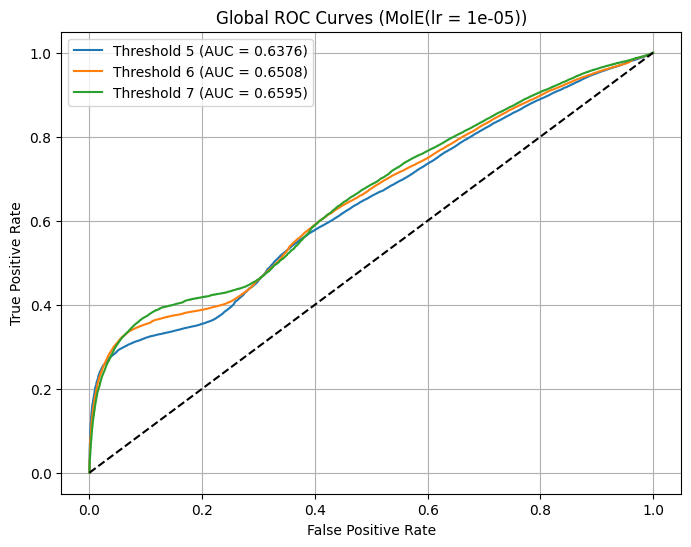

In [18]:
metrics = calculate_global_metric(df00, df1, thresholds=[5,6,7], model_name="MolE(lr = 1e-05)")

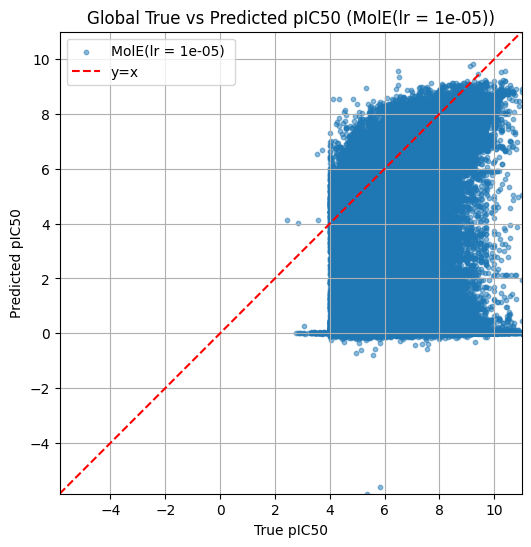

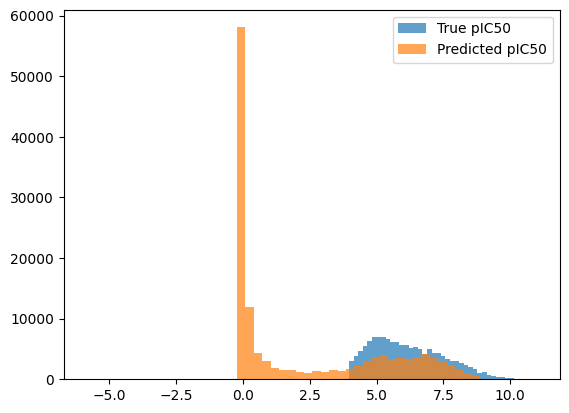

Mean of true values: 6.171844022755179
Mean of predicted values: 2.3321061078525056
Global Metrics (MolE(lr = 1e-05)):
Global MSE (unmasked): 0.007114
Masked MSE (excluding zeros): 22.568429
RMSE (masked): 4.7506
MAE (masked): 3.9883


In [7]:
results = calculate_global_regression_metrics(df00, df1, model_name="MolE(lr = 1e-05)")

## 2. MolE (lr = 1e-04)

In [5]:
df2 =  pd.read_parquet('../data/results/predictions_MolE_lr_1e-04.parquet')


Results for Threshold = 5 (MolE(lr = 1e-04)):
Global AUC: 0.6349
Accuracy: 0.4673
Precision: 0.9403
Recall: 0.3327
F1-score: 0.4915
Confusion Matrix:
[[28324  2205]
 [69689 34748]]

Results for Threshold = 6 (MolE(lr = 1e-04)):
Global AUC: 0.6511
Accuracy: 0.6439
Precision: 0.8871
Recall: 0.3167
F1-score: 0.4667
Confusion Matrix:
[[65868  2678]
 [45388 21032]]

Results for Threshold = 7 (MolE(lr = 1e-04)):
Global AUC: 0.6629
Accuracy: 0.7745
Precision: 0.8241
Recall: 0.2175
F1-score: 0.3442
Confusion Matrix:
[[96552  1704]
 [28726  7984]]


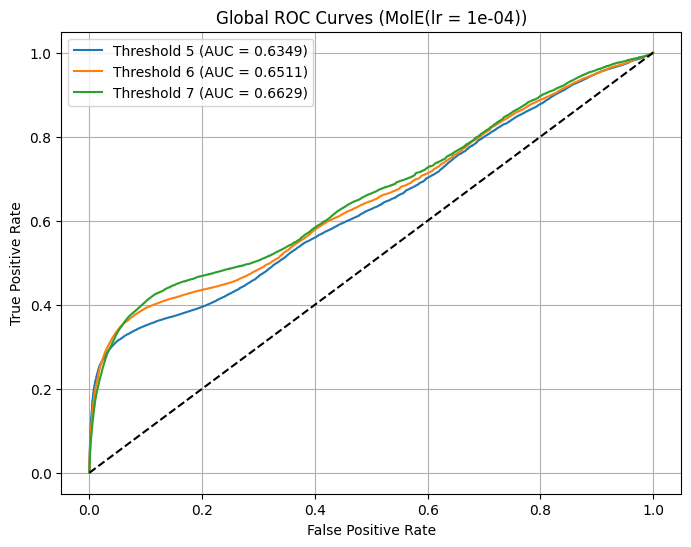

In [13]:
metrics = calculate_global_metric(df00, df2, thresholds=[5,6,7], model_name="MolE(lr = 1e-04)")

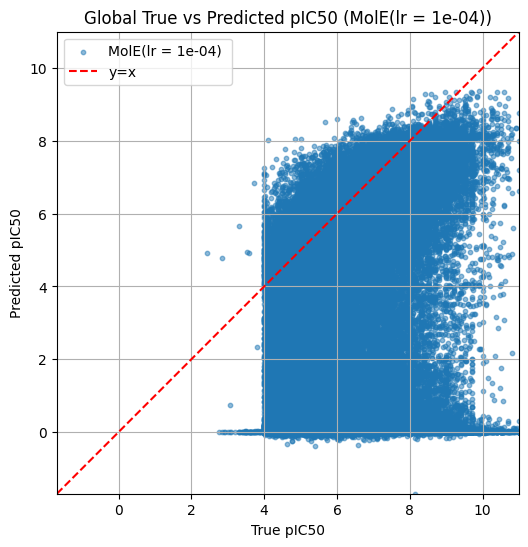

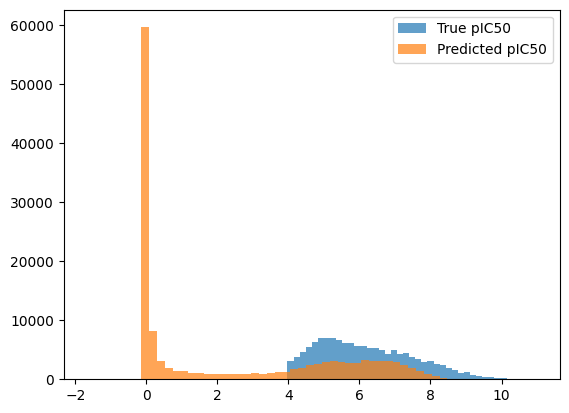

Mean of true values: 6.171844022755179
Mean of predicted values: 2.3829122
Global Metrics (MolE(lr = 1e-04)):
Global MSE (unmasked): 0.006758
Masked MSE (excluding zeros): 21.794939
RMSE (masked): 4.6685
MAE (masked): 3.8917


In [9]:
results2 = calculate_global_regression_metrics(df00, df2, model_name="MolE(lr = 1e-04)")

In [27]:
results = calculate_mse_by_target_type2(
    df00, df2,
    target_dict_path="../data/raw/updated_target_to_index_dictionary_unsorted.txt",
    mapping_path="../data/raw/target_mapping.csv",
    model_name="MolE"
)


Model: MolE
Global MSE: 0.0068
Masked MSE: 21.7949

Target Type: SINGLE PROTEIN
  Global MSE: 0.0066
  Masked MSE: 22.4644

Target Type: CELL-LINE
  Global MSE: 0.0074
  Masked MSE: 19.5370

Target Type: ORGANISM
  Global MSE: 0.0062
  Masked MSE: 21.7152

Target Type: PROTEIN COMPLEX
  Global MSE: 0.0059
  Masked MSE: 29.8062

Target Type: PROTEIN FAMILY
  Global MSE: 0.0073
  Masked MSE: 27.6665



In [25]:
results = compute_auc_by_target_type(df00, df2,target_dict_path="../data/raw/updated_target_to_index_dictionary_unsorted.txt",
    mapping_path="../data/raw/target_mapping.csv")

整体AUC: 0.662895
SINGLE PROTEIN AUC: 0.6958009243
CELL-LINE AUC: 0.5352839547
ORGANISM AUC: 0.6885567576
PROTEIN COMPLEX AUC: 0.6352830345
PROTEIN FAMILY AUC: 0.6514866936


In [26]:
results = compute_auc_by_target_type(df00, df2,target_dict_path="../data/raw/updated_target_to_index_dictionary_unsorted.txt",
    mapping_path="../data/raw/target_mapping.csv", threshold = 6)

整体AUC: 0.651121
SINGLE PROTEIN AUC: 0.7064674076
CELL-LINE AUC: 0.5461423591
ORGANISM AUC: 0.6798720007
PROTEIN COMPLEX AUC: 0.6562730729
PROTEIN FAMILY AUC: 0.6914308917



Model: MolE
Global MSE: 0.0068
Masked MSE: 21.7949

Target Type: SINGLE PROTEIN
  Global MSE: 0.0066
  Masked MSE: 22.4644
  RMSE: 4.7397
  MAE: 3.9126
  Mean True pIC50: 6.5262
  Mean Pred pIC50: 2.7346


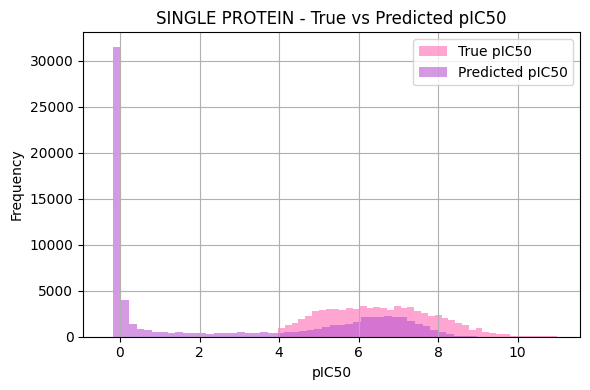

Target Type: CELL-LINE
  Global MSE: 0.0074
  Masked MSE: 19.5370
  RMSE: 4.4201
  MAE: 3.6903
  Mean True pIC50: 5.6055
  Mean Pred pIC50: 1.9927


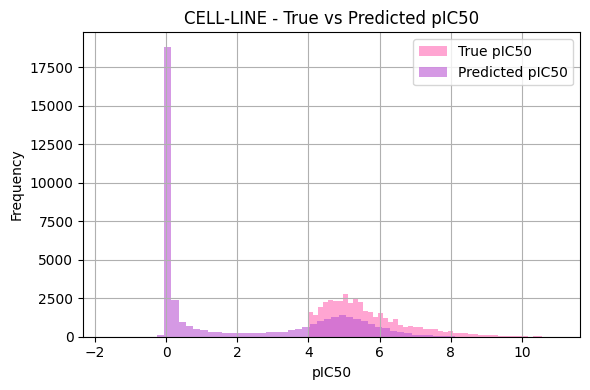

Target Type: ORGANISM
  Global MSE: 0.0062
  Masked MSE: 21.7152
  RMSE: 4.6600
  MAE: 3.9822
  Mean True pIC50: 5.8880
  Mean Pred pIC50: 2.0019


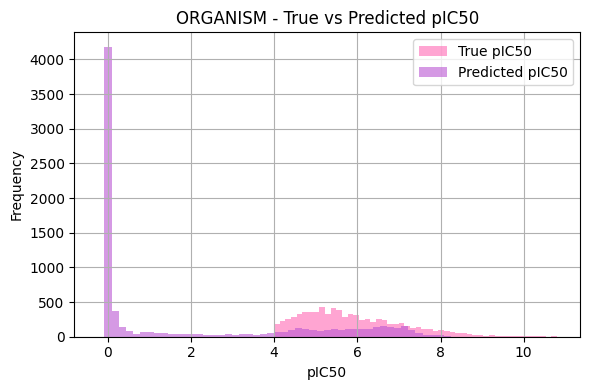

Target Type: PROTEIN COMPLEX
  Global MSE: 0.0059
  Masked MSE: 29.8062
  RMSE: 5.4595
  MAE: 5.0009
  Mean True pIC50: 6.5379
  Mean Pred pIC50: 1.5753


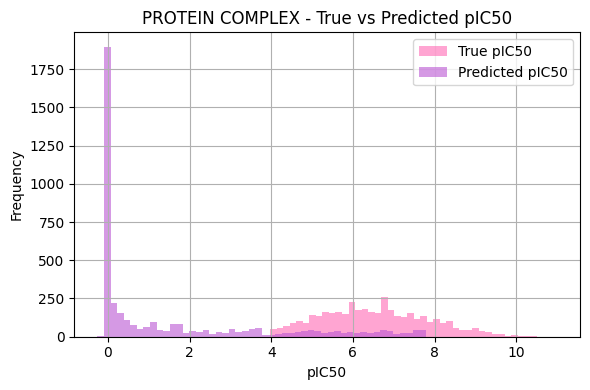

Target Type: PROTEIN FAMILY
  Global MSE: 0.0073
  Masked MSE: 27.6665
  RMSE: 5.2599
  MAE: 4.6048
  Mean True pIC50: 6.5114
  Mean Pred pIC50: 2.0205


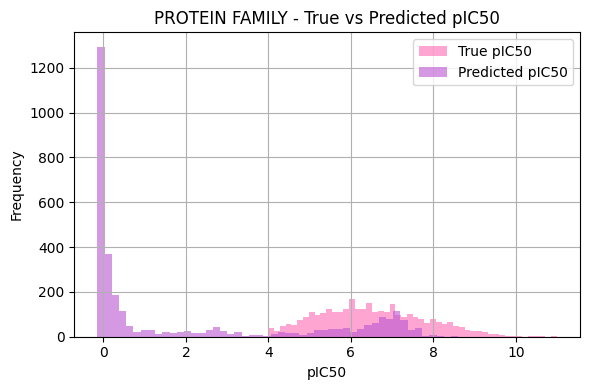

In [19]:
results = calculate_mse_all(
    df00, df2,
    target_dict_path="../data/raw/updated_target_to_index_dictionary_unsorted.txt",
    mapping_path="../data/raw/target_mapping.csv",
    model_name="MolE"
)

## 3. Online Random Forest

In [5]:
df3 = pd.read_parquet('../data/results/predictions_RF_online.parquet')

In [29]:
results = calculate_mse_by_target_type2(
    df00, df3,
    target_dict_path="../data/raw/updated_target_to_index_dictionary_unsorted.txt",
    mapping_path="../data/raw/target_mapping.csv",
    model_name="Online RF"
)


Model: Online RF
Global MSE: 0.0107
Masked MSE: 37.2993

Target Type: SINGLE PROTEIN
  Global MSE: 0.0112
  Masked MSE: 40.9510

Target Type: CELL-LINE
  Global MSE: 0.0109
  Masked MSE: 31.1748

Target Type: ORGANISM
  Global MSE: 0.0092
  Masked MSE: 34.3061

Target Type: PROTEIN COMPLEX
  Global MSE: 0.0079
  Masked MSE: 43.8334

Target Type: PROTEIN FAMILY
  Global MSE: 0.0106
  Masked MSE: 42.2872




Results for Threshold = 5 (Random Forest):
Global AUC: 0.5403
Accuracy: 0.2393
Precision: 0.9933
Recall: 0.0170
F1-score: 0.0335
Confusion Matrix:
[[ 30517     12]
 [102659   1778]]

Results for Threshold = 6 (Random Forest):
Global AUC: 0.5452
Accuracy: 0.5145
Precision: 0.9265
Recall: 0.0146
F1-score: 0.0288
Confusion Matrix:
[[68469    77]
 [65450   970]]

Results for Threshold = 7 (Random Forest):
Global AUC: 0.5559
Accuracy: 0.7309
Precision: 0.8801
Recall: 0.0124
F1-score: 0.0244
Confusion Matrix:
[[98194    62]
 [36255   455]]


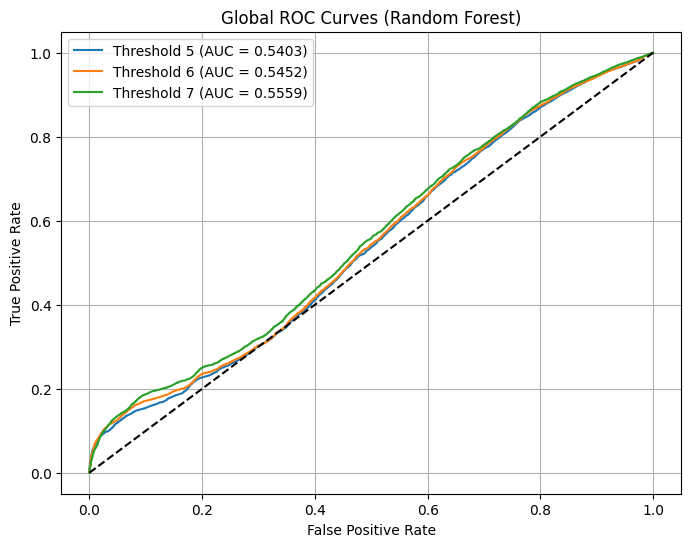

In [11]:
metrics = calculate_global_metric(df00, df3, thresholds=[5,6,7], model_name="Random Forest")

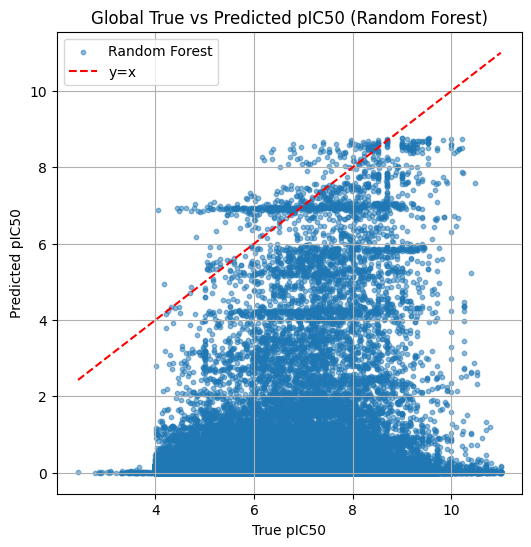

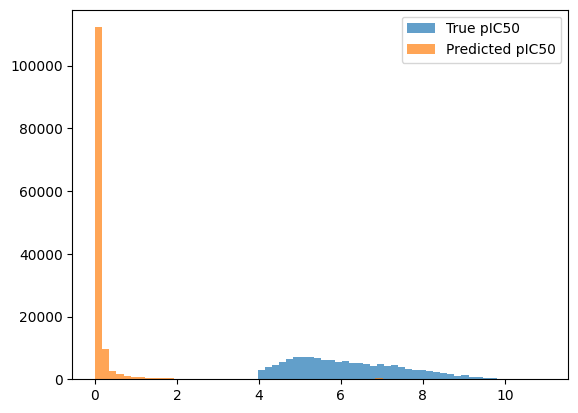

Mean of true values: 6.171844022755179
Mean of predicted values: 0.24566914338815704
Global Metrics (Random Forest):
Global MSE (unmasked): 0.010715
Masked MSE (excluding zeros): 37.299265
RMSE (masked): 6.1073
MAE (masked): 5.9297


In [38]:
results3 = calculate_global_regression_metrics(df00, df3, model_name="Random Forest")

In [6]:
results = compute_auc_by_target_type(df00, df3,target_dict_path="../data/raw/updated_target_to_index_dictionary_unsorted.txt",
    mapping_path="../data/raw/target_mapping.csv", threshold = 5)

整体AUC: 0.540316
SINGLE PROTEIN AUC: 0.6456625726
CELL-LINE AUC: 0.5160025413
ORGANISM AUC: 0.6071301427
PROTEIN COMPLEX AUC: 0.6102209846
PROTEIN FAMILY AUC: 0.6477733635


In [7]:
results = compute_auc_by_target_type(df00, df3,target_dict_path="../data/raw/updated_target_to_index_dictionary_unsorted.txt",
    mapping_path="../data/raw/target_mapping.csv", threshold = 6)

整体AUC: 0.545234
SINGLE PROTEIN AUC: 0.6380562943
CELL-LINE AUC: 0.4923129609
ORGANISM AUC: 0.6213793221
PROTEIN COMPLEX AUC: 0.5809874353
PROTEIN FAMILY AUC: 0.6206773918


In [ ]:
results = compute_auc_by_target_type(df00, df3,target_dict_path="../data/raw/updated_target_to_index_dictionary_unsorted.txt",
    mapping_path="../data/raw/target_mapping.csv", threshold = 7)

整体AUC: 0.555885
SINGLE PROTEIN AUC: 0.6248092323
CELL-LINE AUC: 0.4865823059
ORGANISM AUC: 0.6176647090
PROTEIN COMPLEX AUC: 0.5863888388
PROTEIN FAMILY AUC: 0.5868912125


## 4. KNN

In [16]:
df4 = pd.read_parquet('../data/results/predictions_KNN.parquet')


Model: KNN
Global MSE: 0.0039
Masked MSE: 8.1363

Target Type: SINGLE PROTEIN
  Global MSE: 0.0029
  Masked MSE: 6.3975
  RMSE: 2.5293
  MAE: 1.6576
  Mean True pIC50: 6.5262
  Mean Pred pIC50: 5.1837


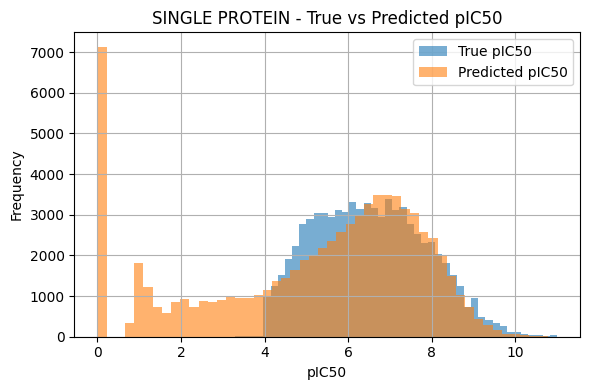

Target Type: CELL-LINE
  Global MSE: 0.0065
  Masked MSE: 11.2873
  RMSE: 3.3597
  MAE: 2.4946
  Mean True pIC50: 5.6055
  Mean Pred pIC50: 3.2362


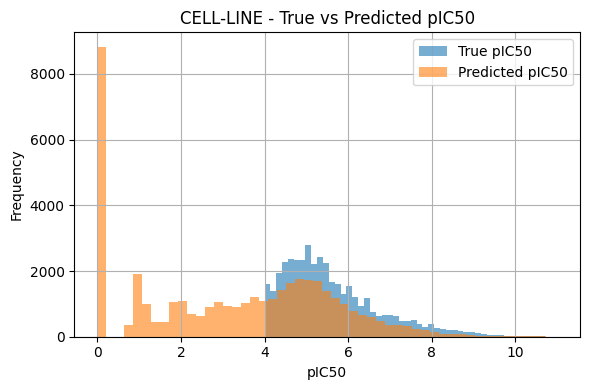

Target Type: ORGANISM
  Global MSE: 0.0039
  Masked MSE: 8.7543
  RMSE: 2.9588
  MAE: 2.1639
  Mean True pIC50: 5.8880
  Mean Pred pIC50: 3.9249


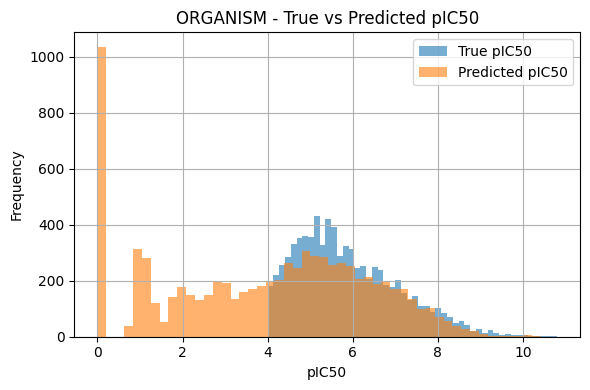

Target Type: PROTEIN COMPLEX
  Global MSE: 0.0023
  Masked MSE: 6.9597
  RMSE: 2.6381
  MAE: 1.7649
  Mean True pIC50: 6.5379
  Mean Pred pIC50: 5.0678


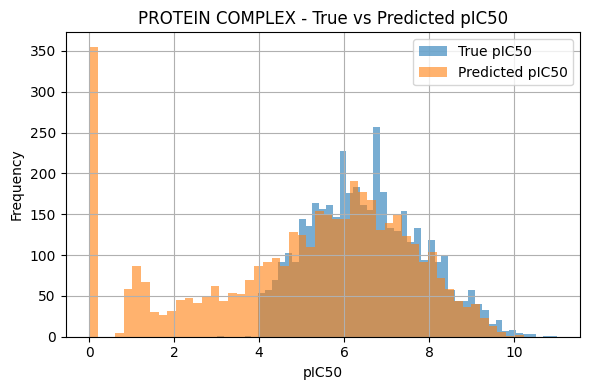

Target Type: PROTEIN FAMILY
  Global MSE: 0.0035
  Masked MSE: 7.7996
  RMSE: 2.7928
  MAE: 1.9325
  Mean True pIC50: 6.5114
  Mean Pred pIC50: 4.8853


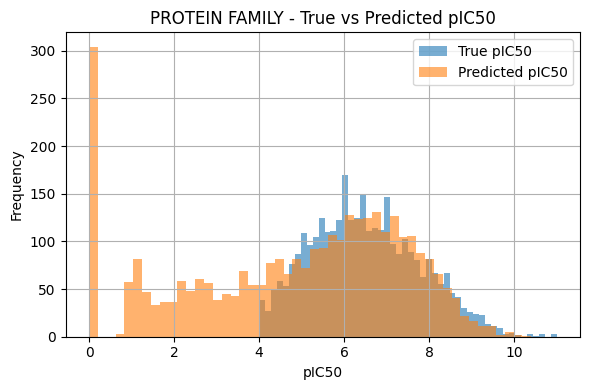

In [17]:
results = calculate_mse_all(
    df00, df4,
    target_dict_path="../data/raw/updated_target_to_index_dictionary_unsorted.txt",
    mapping_path="../data/raw/target_mapping.csv",
    model_name="KNN"
)

In [9]:
results = calculate_mse_by_target_type2(
    df00, df4,
    target_dict_path="../data/raw/updated_target_to_index_dictionary_unsorted.txt",
    mapping_path="../data/raw/target_mapping.csv",
    model_name="KNN"
)


Model: KNN
Global MSE: 0.0039
Masked MSE: 8.1363

Target Type: SINGLE PROTEIN
  Global MSE: 0.0029
  Masked MSE: 6.3975

Target Type: CELL-LINE
  Global MSE: 0.0065
  Masked MSE: 11.2873

Target Type: ORGANISM
  Global MSE: 0.0039
  Masked MSE: 8.7543

Target Type: PROTEIN COMPLEX
  Global MSE: 0.0023
  Masked MSE: 6.9597

Target Type: PROTEIN FAMILY
  Global MSE: 0.0035
  Masked MSE: 7.7996




Results for Threshold = 5 (KNN):
Global AUC: 0.7616
Accuracy: 0.6633
Precision: 0.9471
Recall: 0.5983
F1-score: 0.7333
Confusion Matrix:
[[27040  3489]
 [41952 62485]]

Results for Threshold = 6 (KNN):
Global AUC: 0.7924
Accuracy: 0.7727
Precision: 0.8890
Recall: 0.6149
F1-score: 0.7270
Confusion Matrix:
[[63445  5101]
 [25576 40844]]

Results for Threshold = 7 (KNN):
Global AUC: 0.8036
Accuracy: 0.8472
Precision: 0.8102
Recall: 0.5721
F1-score: 0.6707
Confusion Matrix:
[[93335  4921]
 [15707 21003]]


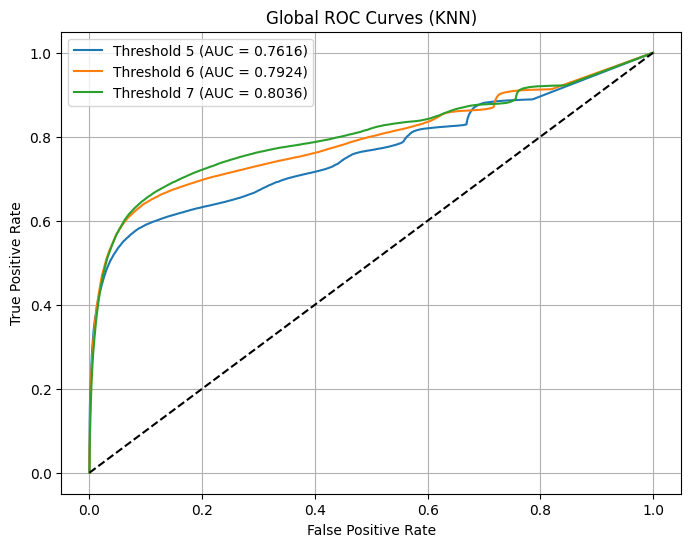

In [26]:
metrics = calculate_global_metric(df00, df4, thresholds=[5,6,7], model_name="KNN")

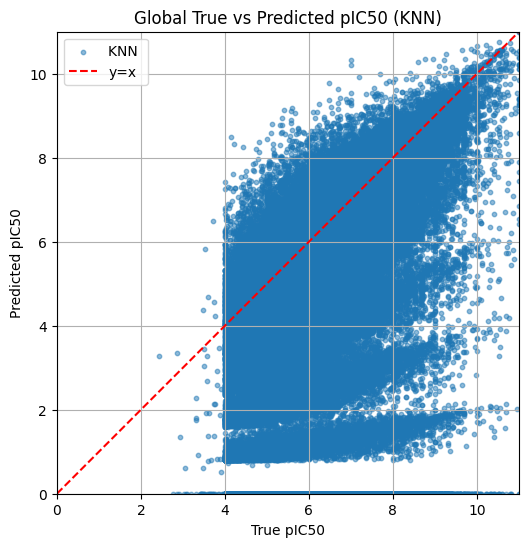

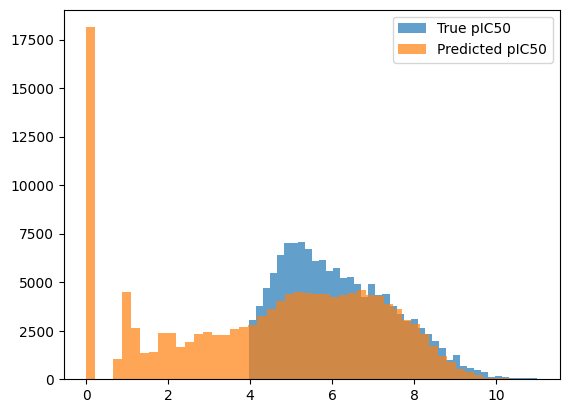

Mean of true values: 6.171844022755179
Mean of predicted values: 4.44645098605523
Global Metrics (KNN):
Global MSE (unmasked): 0.003864
Masked MSE (excluding zeros): 8.136272
RMSE (masked): 2.8524
MAE (masked): 1.9679


In [13]:
results4 = calculate_global_regression_metrics(df00, df4, model_name="KNN")

In [10]:
results = compute_auc_by_target_type(df00, df4,target_dict_path="../data/raw/updated_target_to_index_dictionary_unsorted.txt",
    mapping_path="../data/raw/target_mapping.csv", threshold = 5)

整体AUC: 0.761630
SINGLE PROTEIN AUC: 0.8174490187
CELL-LINE AUC: 0.6298320883
ORGANISM AUC: 0.7058071546
PROTEIN COMPLEX AUC: 0.7630352518
PROTEIN FAMILY AUC: 0.7693474811


In [12]:
results = compute_auc_by_target_type(df00, df4,target_dict_path="../data/raw/updated_target_to_index_dictionary_unsorted.txt",
    mapping_path="../data/raw/target_mapping.csv", threshold = 6)

整体AUC: 0.792358
SINGLE PROTEIN AUC: 0.8329671822
CELL-LINE AUC: 0.6154002273
ORGANISM AUC: 0.7332614737
PROTEIN COMPLEX AUC: 0.7671237758
PROTEIN FAMILY AUC: 0.7772195853


In [13]:
results = compute_auc_by_target_type(df00, df4,target_dict_path="../data/raw/updated_target_to_index_dictionary_unsorted.txt",
    mapping_path="../data/raw/target_mapping.csv", threshold = 7)

整体AUC: 0.803568
SINGLE PROTEIN AUC: 0.8315887088
CELL-LINE AUC: 0.5975443714
ORGANISM AUC: 0.7563120464
PROTEIN COMPLEX AUC: 0.7641667795
PROTEIN FAMILY AUC: 0.7683619527


## 5. XGBoost

In [15]:
df5  =pd.read_parquet("../data/results/prediction_XGB.parquet")

In [ ]:
results = calculate_mse_all(
    df00, df5,
    target_dict_path="../data/raw/updated_target_to_index_dictionary_unsorted.txt",
    mapping_path="../data/raw/target_mapping.csv",
    model_name=""
)

In [11]:
results = calculate_mse_by_target_type2(
    df00, df5,
    target_dict_path="../data/raw/updated_target_to_index_dictionary_unsorted.txt",
    mapping_path="../data/raw/target_mapping.csv",
    model_name="XGBoost"
)


Model: XGBoost
Global MSE: 0.0044
Masked MSE: 12.3405

Target Type: SINGLE PROTEIN
  Global MSE: 0.0032
  Masked MSE: 9.0241

Target Type: CELL-LINE
  Global MSE: 0.0072
  Masked MSE: 17.5598

Target Type: ORGANISM
  Global MSE: 0.0048
  Masked MSE: 15.1789

Target Type: PROTEIN COMPLEX
  Global MSE: 0.0023
  Masked MSE: 8.5482

Target Type: PROTEIN FAMILY
  Global MSE: 0.0035
  Masked MSE: 10.3260




Results for Threshold = 5 (XGBoost(STL)):
Global AUC: 0.7481
Accuracy: 0.5737
Precision: 0.9709
Recall: 0.4630
F1-score: 0.6270
Confusion Matrix:
[[29078  1451]
 [56083 48354]]

Results for Threshold = 6 (XGBoost(STL)):
Global AUC: 0.7771
Accuracy: 0.7262
Precision: 0.9200
Recall: 0.4859
F1-score: 0.6359
Confusion Matrix:
[[65740  2806]
 [34148 32272]]

Results for Threshold = 7 (XGBoost(STL)):
Global AUC: 0.7878
Accuracy: 0.8258
Precision: 0.8460
Recall: 0.4396
F1-score: 0.5786
Confusion Matrix:
[[95319  2937]
 [20573 16137]]


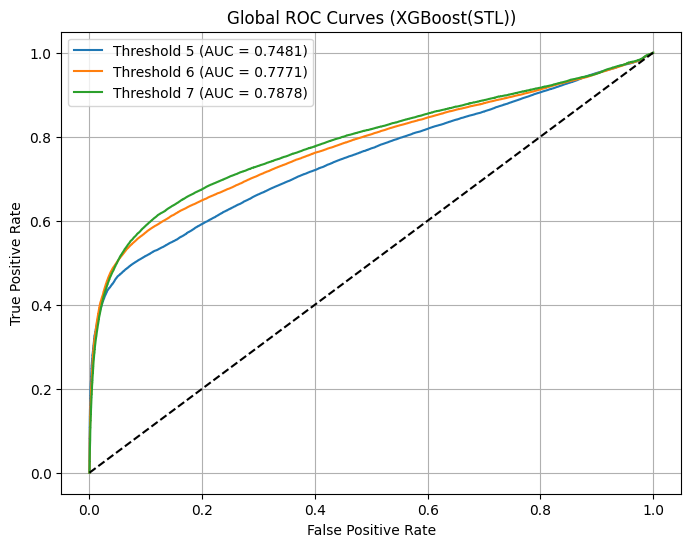

In [28]:
metrics = calculate_global_metric(df00, df5, thresholds=[5,6,7], model_name="XGBoost(STL)")

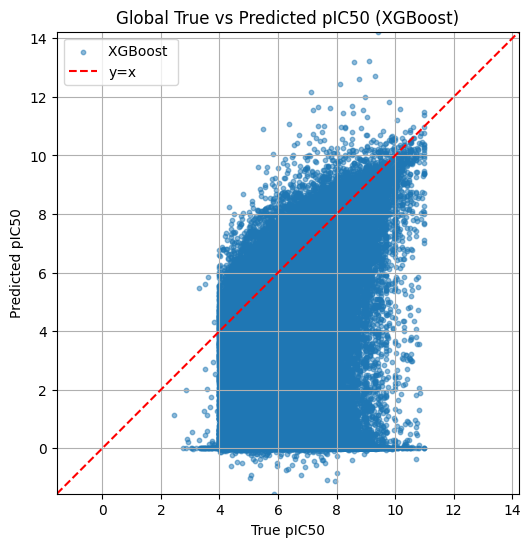

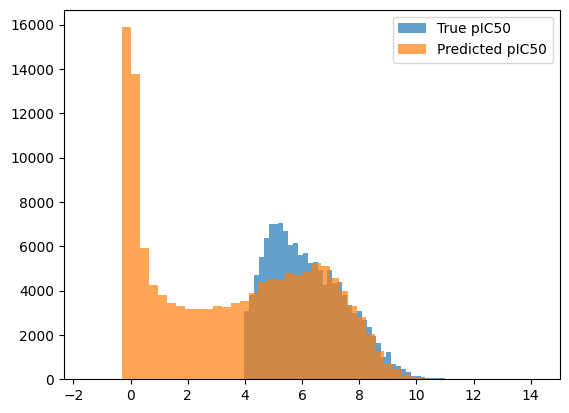

Mean of true values: 6.171844022755179
Mean of predicted values: 3.575013364430806
Global Metrics (XGBoost):
Global MSE (unmasked): 0.004398
Masked MSE (excluding zeros): 12.340501
RMSE (masked): 3.5129
MAE (masked): 2.7356


In [11]:
results5 = calculate_global_regression_metrics(df00, df5, model_name="XGBoost")

In [16]:
results = compute_auc_by_target_type(df00, df5,target_dict_path="../data/raw/updated_target_to_index_dictionary_unsorted.txt",
    mapping_path="../data/raw/target_mapping.csv", threshold = 6)

整体AUC: 0.777115
SINGLE PROTEIN AUC: 0.8121531642
CELL-LINE AUC: 0.5887164380
ORGANISM AUC: 0.6866150002
PROTEIN COMPLEX AUC: 0.7641411130
PROTEIN FAMILY AUC: 0.7657145657
